In [2]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [3]:
# generate a random maxcut problem
from rbnbr.problems.max_cut import MaxCutProblem
from rbnbr.problems.problem_base import ProblemSet
from tqdm.notebook import tqdm
from pathlib import Path

# Define problem sizes and paths
sizes = [5, 10, 14, 15, 20]
save_paths = {
    size: Path(f'./problems/sets/problem_set{size}.pkl') 
    for size in sizes
}

# Initialize problem vault
problem_vault = {
    size: ProblemSet() for size in sizes
}

# Load existing problem set for size 20
problem_vault[20] = ProblemSet.load_problems(save_paths[20])

# Generate or load problem sets for sizes 10 and 15
for size in sizes:
    if save_paths[size].exists():
        problem_vault[size] = ProblemSet.load_problems(save_paths[size])
    else:
        save_paths[size].parent.mkdir(parents=True, exist_ok=True)
        for _ in tqdm(range(10)):
            problem_vault[size].add_problem(
                MaxCutProblem.generate_random_maxcut_problem(
                    size, 0.3, weighted=False
                )
            )
        problem_vault[size].save_problems(save_paths[size])
    
    

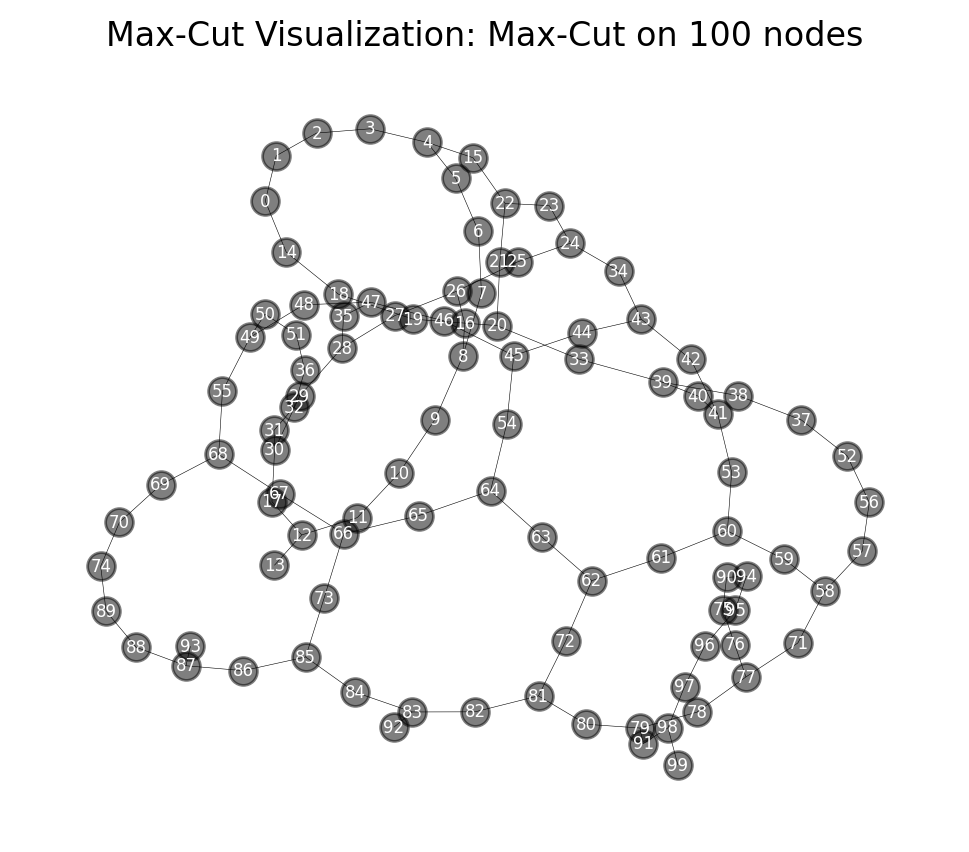

In [4]:
from rbnbr.problems.read_mc import coupling_map
problem_cm = coupling_map(100)
problem_cm.display();
problem = problem_cm

from rbnbr.solver.classical.brute_force import BruteForceMaxCutSolver

problem = problem_cm
bf_solver = BruteForceMaxCutSolver()
bf_breadcrumbs = bf_solver.solve(problem)




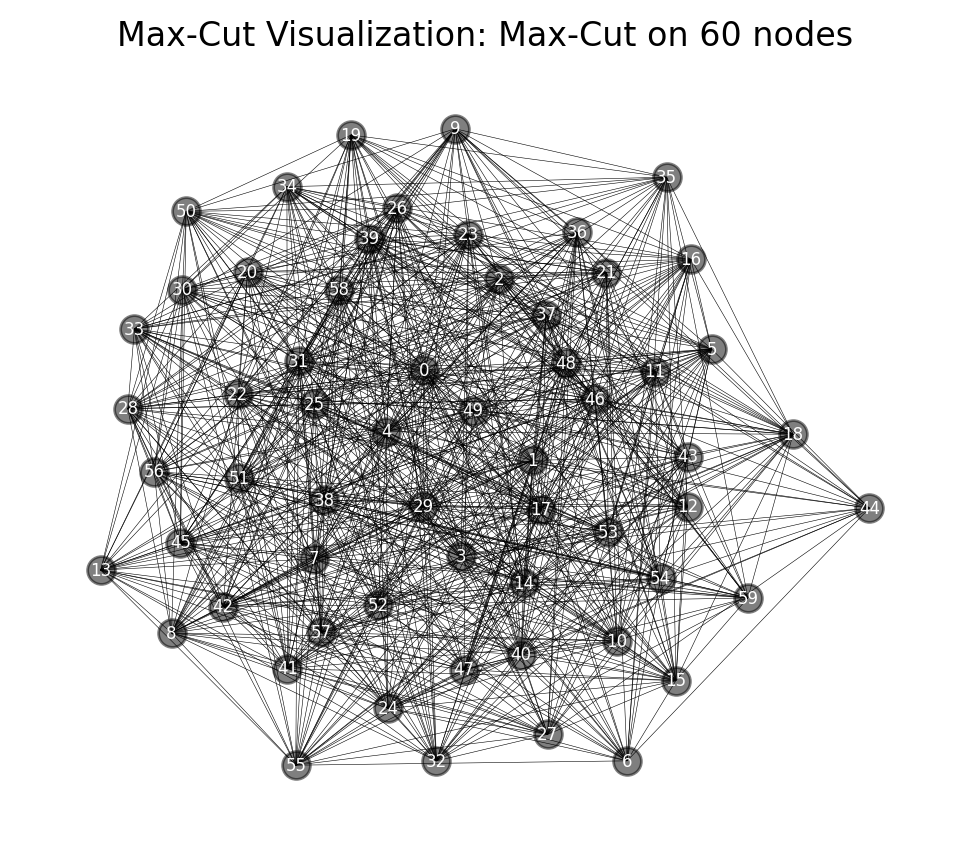

In [5]:
from rbnbr.problems.read_mc import read_mc
problem60 = read_mc('./problems/bq/g05_60.0.mc', solution_value=536, keep_prob=1)
problem60.display();

21


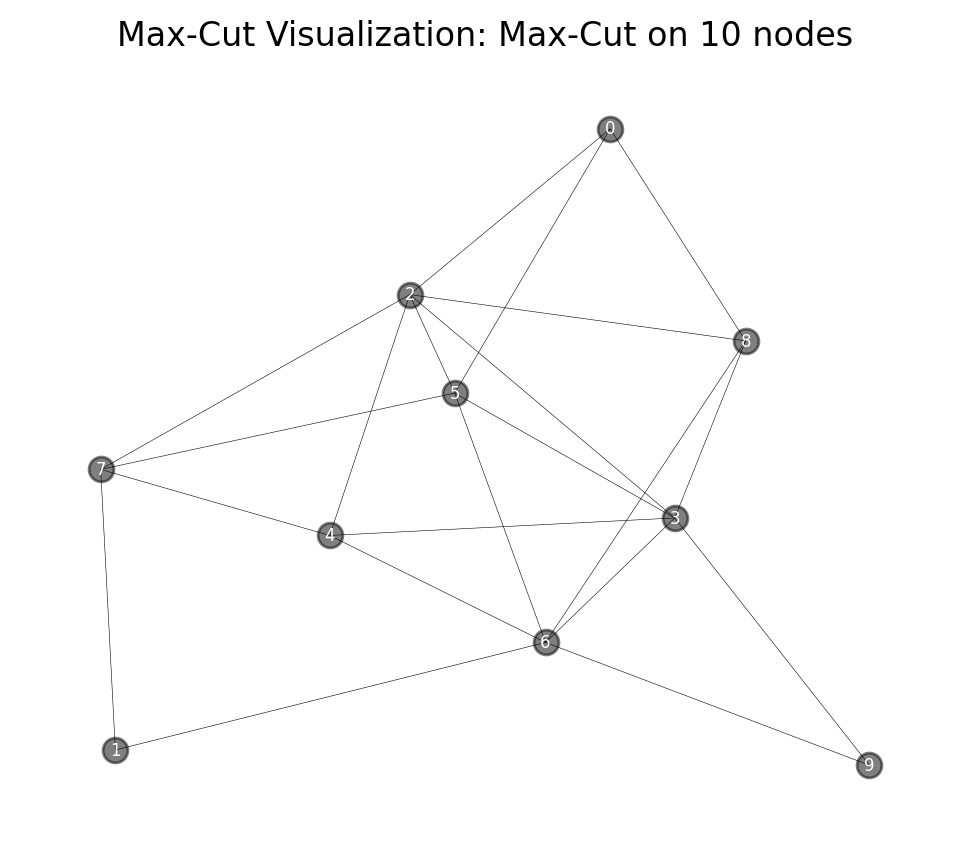

In [6]:
problem_rnd = MaxCutProblem.generate_random_maxcut_problem(10, 0.5, weighted=False, solve=False)
print(problem_rnd.graph.number_of_edges())
problem_rnd.display(vis_opts={'node_size': 80}, show_edge_labels=False);


problem = problem60
from rbnbr.solver.classical.brute_force import BruteForceMaxCutSolver
solver = BruteForceMaxCutSolver()
breadcrumbs = solver.solve(problem)
problem.add_solution('brute_force', breadcrumbs)
problem.display(breadcrumbs.solution, show_edge_labels=True);
breadcrumbs.cost


In [7]:
from rbnbr.solver.quantum.resources import QuantumResources
q_dev = QuantumResources(
    n_shots=1024,
    on_hardware=True,
    is_real_backend=False,
    n_bits=127,
)

# Try the algorithms

In [11]:
problem = problem_rnd   

In [12]:
from rbnbr.solver.quantum.qaoa import QAOAMaxCutSolver
qaoa_solver = QAOAMaxCutSolver(q_dev=q_dev)

In [13]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# Create single-point correlations (Z operators for each qubit)
num_qubits = problem.graph.number_of_nodes()
single_point_obs = []
for i in range(num_qubits):
    pauli_str = ['I'] * num_qubits
    pauli_str[i] = 'Z'
    single_point_obs.append(SparsePauliOp.from_list([(''.join(pauli_str[::-1]), 1.0)]))

# Create two-point correlations (ZZ operators for each edge)
two_point_obs = []
for i, j in problem.graph.edges():
    pauli_str = ['I'] * num_qubits
    pauli_str[i] = 'Z'
    pauli_str[j] = 'Z'
    two_point_obs.append(SparsePauliOp.from_list([(''.join(pauli_str[::-1]), 1.0)]))

# Combine all observables
observables = single_point_obs + two_point_obs

In [18]:
qaoa_solver = QAOAMaxCutSolver()
qaoa_solver.device_only = True

In [19]:
result, optim_params = qaoa_solver.get_expval(problem)

In [20]:
print(result)
print(optim_params)


-4.580078125
[2.7940514802193204, 0.2733125352937384]


In [21]:
from rbnbr.solver.quantum.exp_p1 import p1_expval_maxcut
p1_expval_maxcut(problem.graph, optim_params[0], optim_params[1])


-18.275173067753645

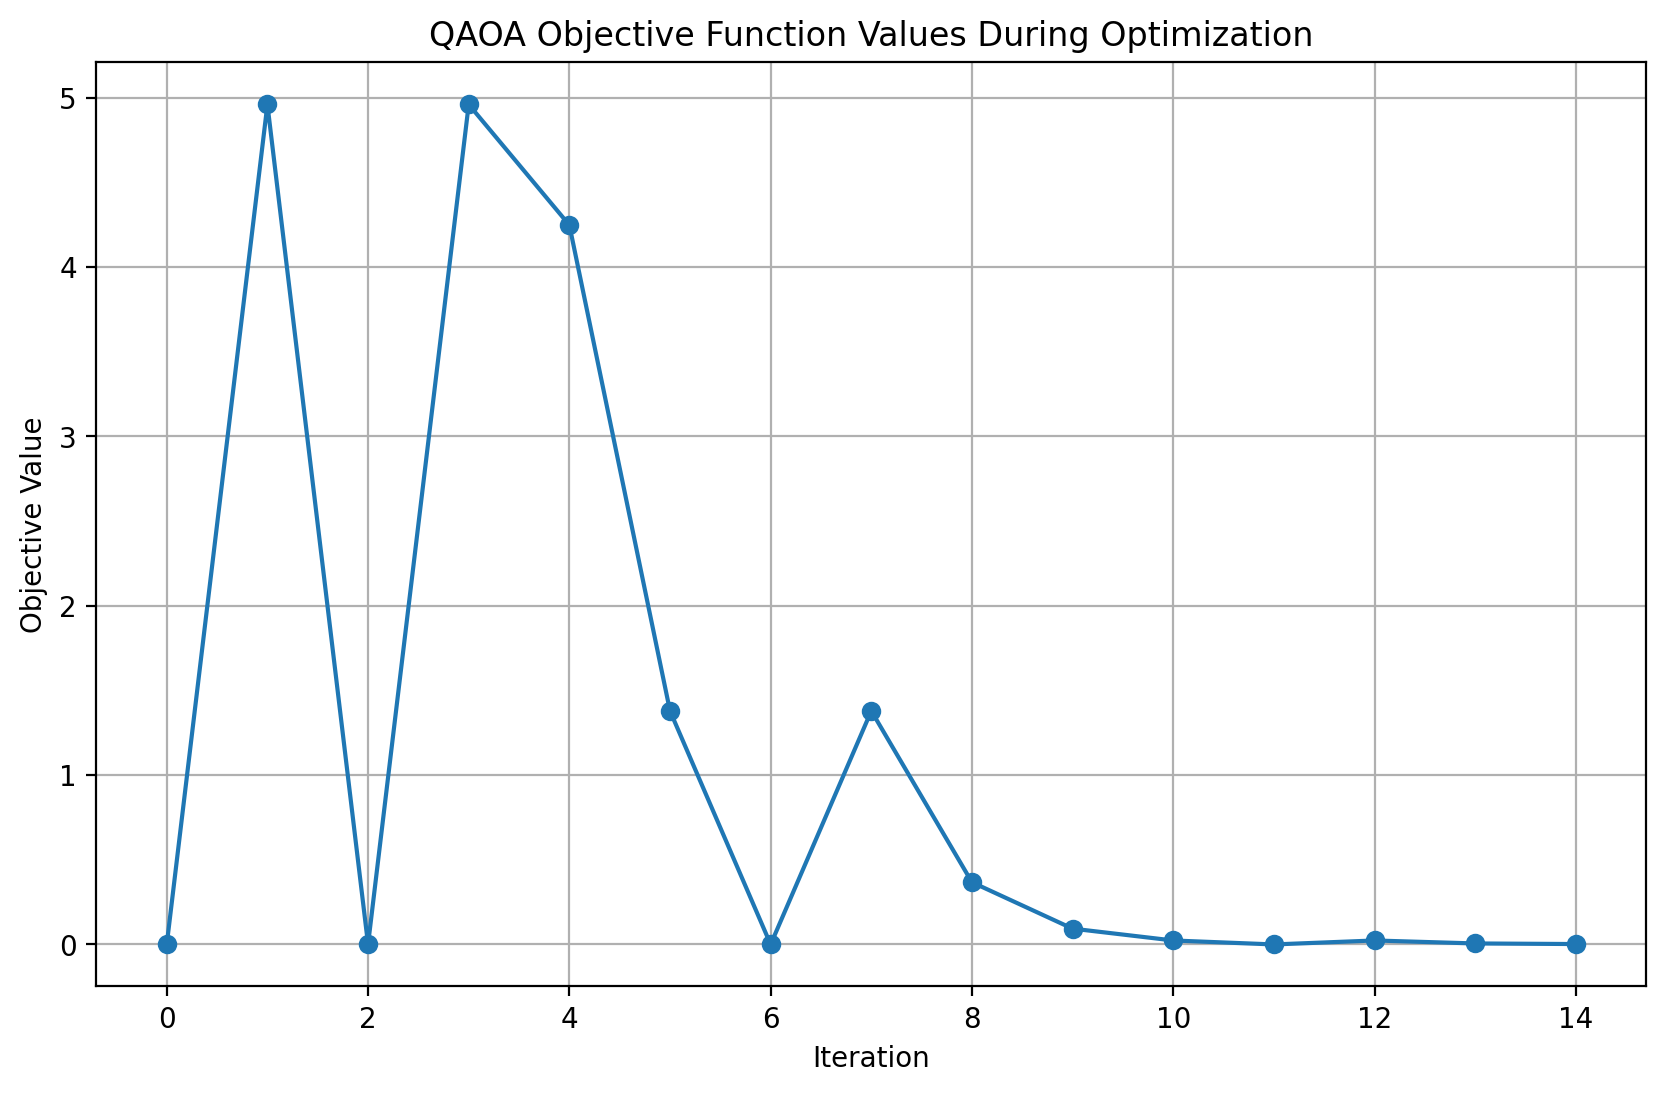

[6.2390006958733276e-30,
 4.960930862590848,
 7.118404518618392e-18,
 4.960930862590828,
 4.248440509641444,
 1.3790930823955705,
 7.314187577480132e-15,
 1.3790930823951522,
 0.3672523143287636,
 0.0932627348681268,
 0.02340699831198194,
 3.909730421514089e-15,
 0.023406998311723562,
 0.0058574678996310345,
 0.002399680017115347]

In [164]:
import matplotlib.pyplot as plt

# Plot the objective function values
plt.figure(figsize=(10, 6))
plt.plot(qaoa_solver.cache_optim_history, marker='o')
plt.title('QAOA Objective Function Values During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.grid(True)
plt.show()

# Also display the raw values
qaoa_solver.cache_optim_history

In [ ]:
import time


start_time = time.time()
qaoa_solver = QAOAMaxCutSolver(q_dev=q_dev)
print(f"Initialize solver: {time.time() - start_time:.4f} seconds")

start_time = time.time()
qaoa_breadcrumbs = qaoa_solver.solve(problem, optim_params=[0.08, 0.01])
print(f"Solve problem: {time.time() - start_time:.4f} seconds")

start_time = time.time()
problem.add_solution('QAOA', qaoa_breadcrumbs)
print(f"Add solution: {time.time() - start_time:.4f} seconds")

start_time = time.time()
problem.display(qaoa_breadcrumbs.solution);
print(f"Display solution: {time.time() - start_time:.4f} seconds")

start_time = time.time()
qaoa_breadcrumbs.cost
print(f"Get cost: {time.time() - start_time:.4f} seconds")

start_time = time.time()
problem.approx_ratio(qaoa_breadcrumbs.solution)
print(f"Calculate approximation ratio: {time.time() - start_time:.4f} seconds")

0.9285714285714286

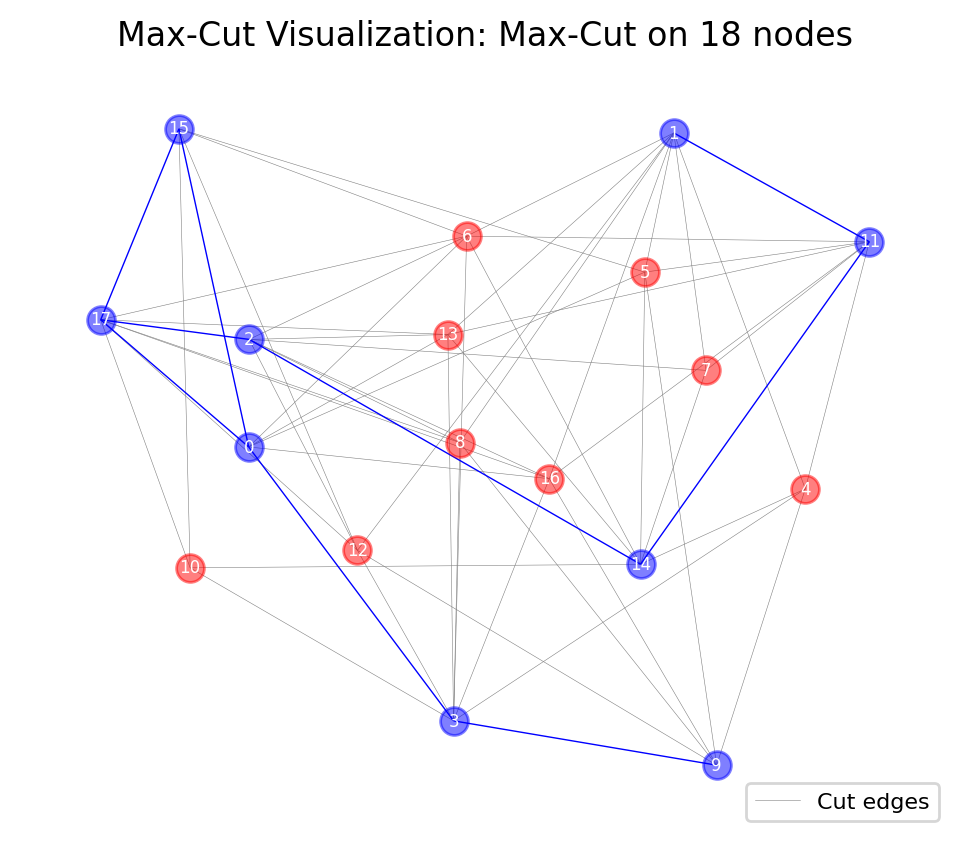

In [7]:

from rbnbr.solver.classical.gw import GWMaxcutSolver
gw_solver = GWMaxcutSolver()
gw_breadcrumbs = gw_solver.solve(problem)
problem.add_solution('Goemans-Williamson', gw_breadcrumbs)
problem.display(gw_breadcrumbs.solution, show_edge_labels=False);
gw_breadcrumbs.cost
gw_breadcrumbs.approx_ratio


0.9107142857142857

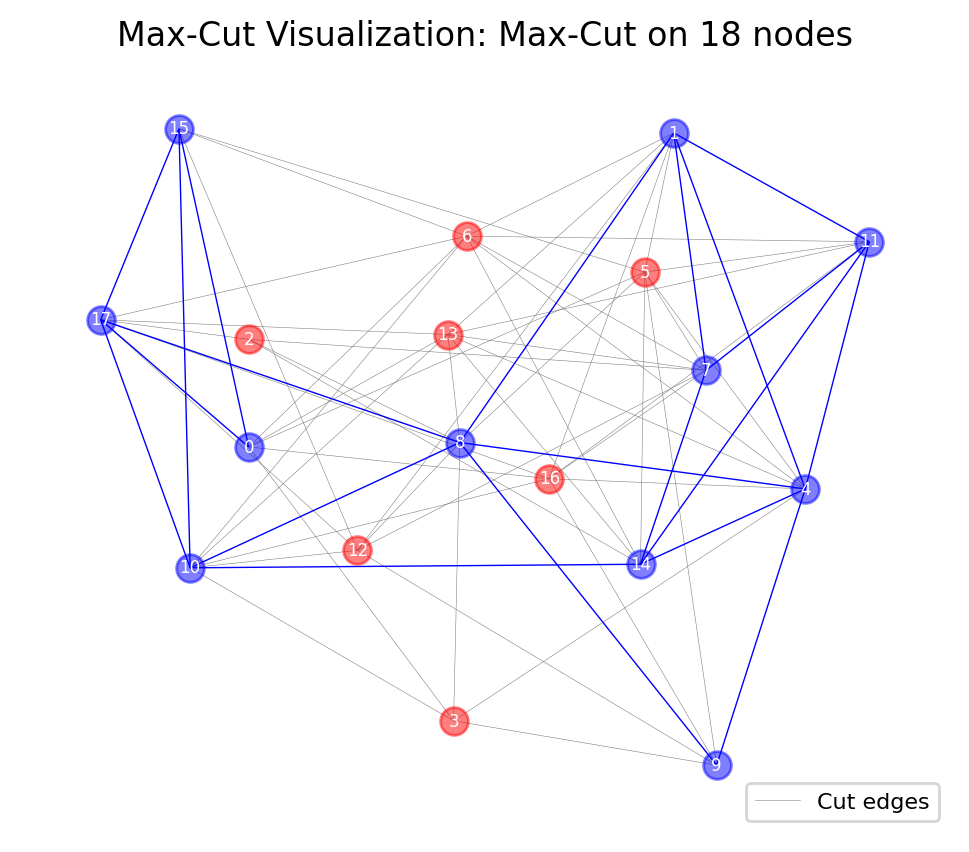

In [8]:
from rbnbr.solver.quantum.qrr import QRRMaxCutSolver
qrr_solver = QRRMaxCutSolver(reps=1)
qrr_solution = qrr_solver.solve(problem, optim_params=qaoa_breadcrumbs.optim_params)
problem.add_solution('QRR', qrr_solution)
problem.display(qrr_solution.solution, show_edge_labels=False);
qrr_solution.cost
qrr_solution.approx_ratio

In [9]:
problem.solutions()['QRR'].cost

51.0

from rbnbr.solver.quantum.qrr import QRRnGWMaxCutSolver
qrrngw_solver = QRRnGWMaxCutSolver()
qrrngw_breadcrumbs = qrrngw_solver.solve(problem, optim_params=qaoa_breadcrumbs.optim_params, qrr_information=qrr_solution.qrr_information)
problem.add_solution('QRRnGW', qrrngw_breadcrumbs)
problem.display(qrrngw_breadcrumbs.solution, show_edge_labels=False);
qrrngw_breadcrumbs.cost
qrrngw_breadcrumbs.approx_ratio

problem.solutions()['QRRnGW'].cost

In [10]:
problem.solution_summary()

,Solution Type,Cut Value
0,Exact,56.0
2,Goemans-Williamson,52.0
3,QRR,51.0
1,QAOA,34.0


0.9821428571428571

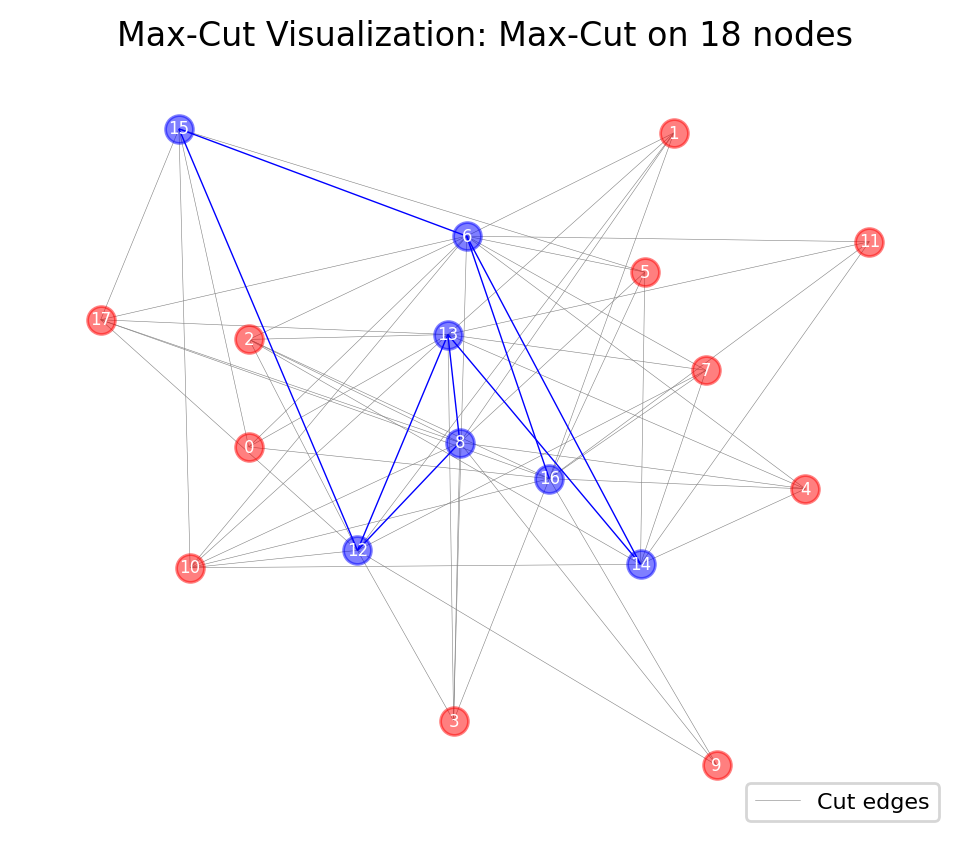

In [11]:
from rbnbr.solver.classical.eigen import EigenSolver
eigen_solver = EigenSolver()
eigen_breadcrumbs = eigen_solver.solve(problem)
problem.add_solution('Eigen', eigen_breadcrumbs)
problem.display(eigen_breadcrumbs.solution, show_edge_labels=True);
eigen_breadcrumbs.cost
eigen_breadcrumbs.approx_ratio

In [12]:
from rbnbr.solver.quantum.rbnbr import Edge_QBB_MC
def run_rbnbr(
    problem,
    *,
    X_type='relaxation',
    strategy='r1',
    topk=3,
    optim_params=None,
    qrr_information=None
):
    rbnbr_solver = Edge_QBB_MC(X_type=X_type, branching_strategy=strategy, topk=topk)
    if qrr_information is not None:
        rbnbr_breadcrumbs = rbnbr_solver.solve(problem, qrr_information=qrr_information)
    elif optim_params is not None:
        rbnbr_breadcrumbs = rbnbr_solver.solve(problem, optim_params=optim_params)
    else:
        rbnbr_breadcrumbs = rbnbr_solver.solve(problem)
    problem.add_solution(f'RBnBR_{strategy}_k={topk}_{X_type}', rbnbr_breadcrumbs)
    problem.display(rbnbr_breadcrumbs.solution, show_edge_labels=False);
    print(f"🎯 Cut value: {rbnbr_breadcrumbs.cost}")
    print(f"✨ Approximation ratio: {rbnbr_breadcrumbs.approx_ratio}")
    print(f"💾 Result saved to problem.solutions()['RBnBR_{strategy}_k={topk}_{X_type}']")



🎯 Cut value: 51.0
✨ Approximation ratio: 0.9107142857142857
💾 Result saved to problem.solutions()['RBnBR_r1_k=3_corr']


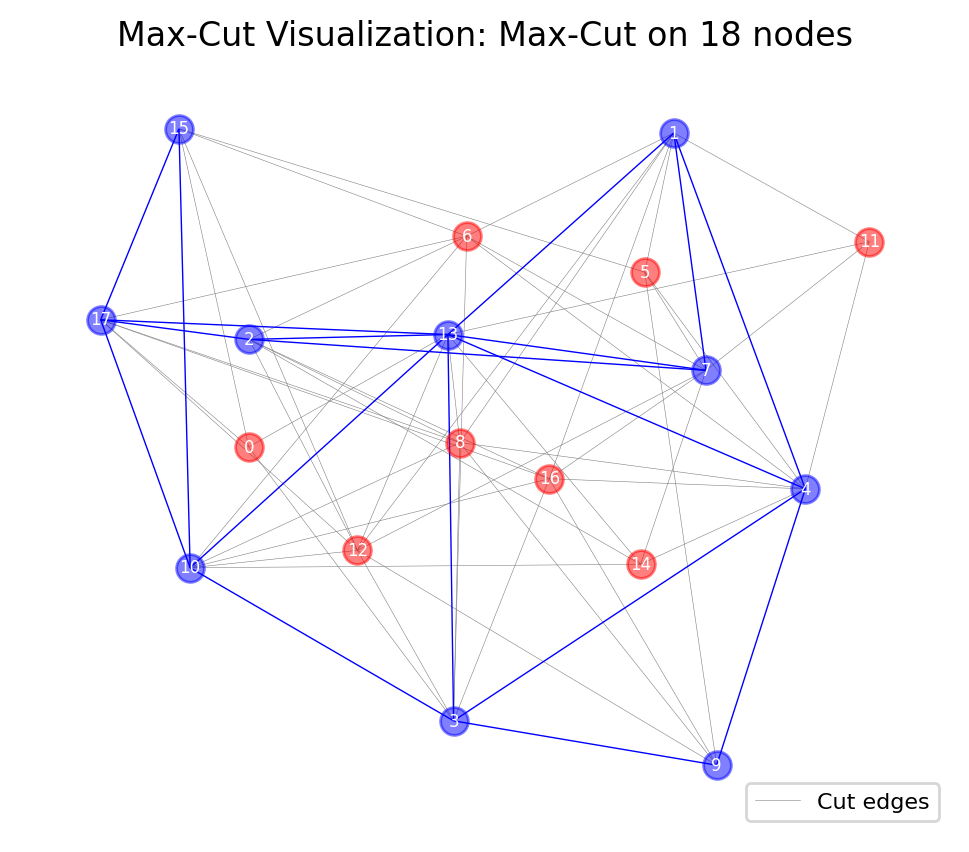

In [13]:
run_rbnbr(
    problem,
    X_type='corr',
    strategy='r1',
    topk=3,
    optim_params=qaoa_breadcrumbs.optim_params,
)

🎯 Cut value: 47.0
✨ Approximation ratio: 0.8392857142857143
💾 Result saved to problem.solutions()['RBnBR_r1_k=3_relaxation']


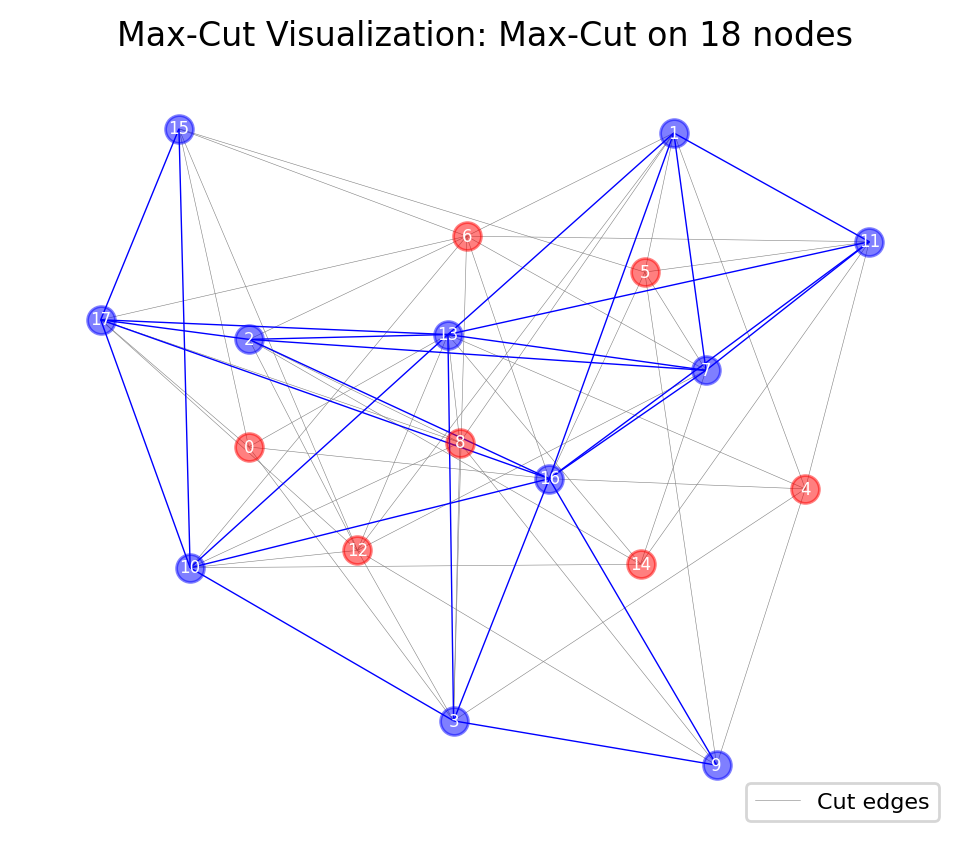

In [14]:
run_rbnbr(
    problem,
    X_type='relaxation',
    strategy='r1',
    topk=3,
    optim_params=qaoa_breadcrumbs.optim_params,
    qrr_information=qrr_solution.qrr_information
)

In [15]:
problem.solutions()['RBnBR_r1_k=3_relaxation'].get_history(['cost'])

,cost
0,47.0
1,47.0


🎯 Cut value: 55.0
✨ Approximation ratio: 0.9821428571428571
💾 Result saved to problem.solutions()['RBnBR_r2_k=3_relaxation']


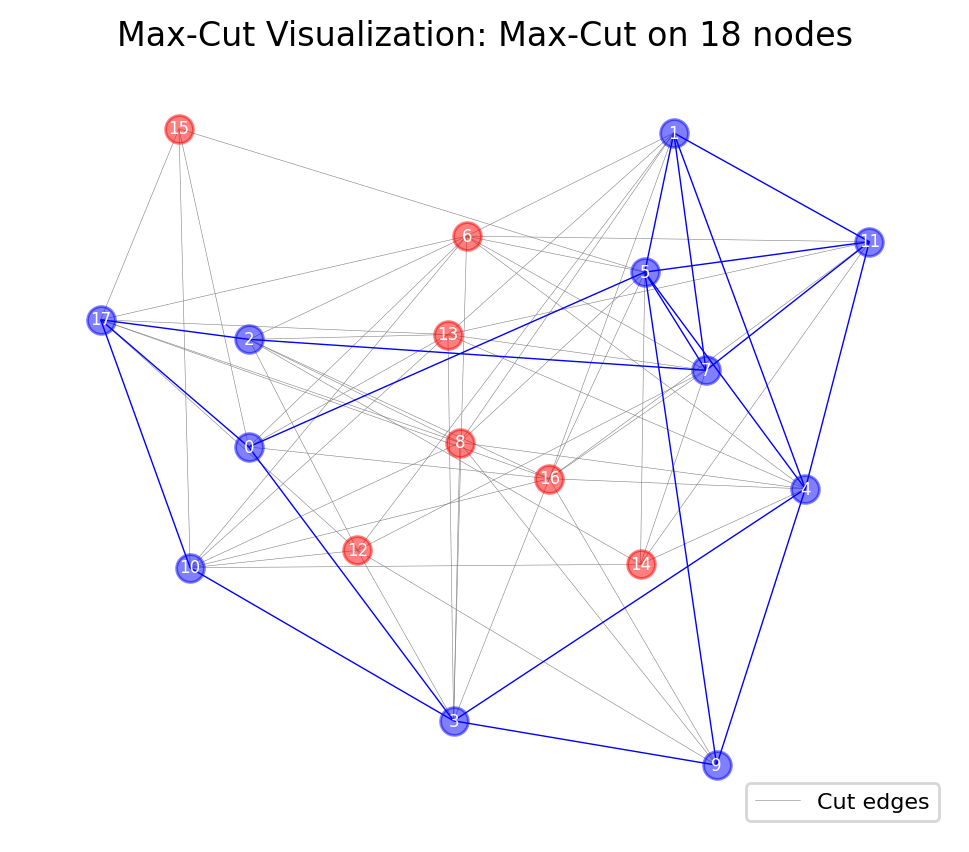

In [16]:
run_rbnbr(
    problem,
    X_type='relaxation',
    strategy='r2',
    topk=3,
    optim_params=qaoa_breadcrumbs.optim_params,
    qrr_information=qrr_solution.qrr_information
)

🎯 Cut value: 54.0
✨ Approximation ratio: 0.9642857142857143
💾 Result saved to problem.solutions()['RBnBR_r3_k=3_relaxation']


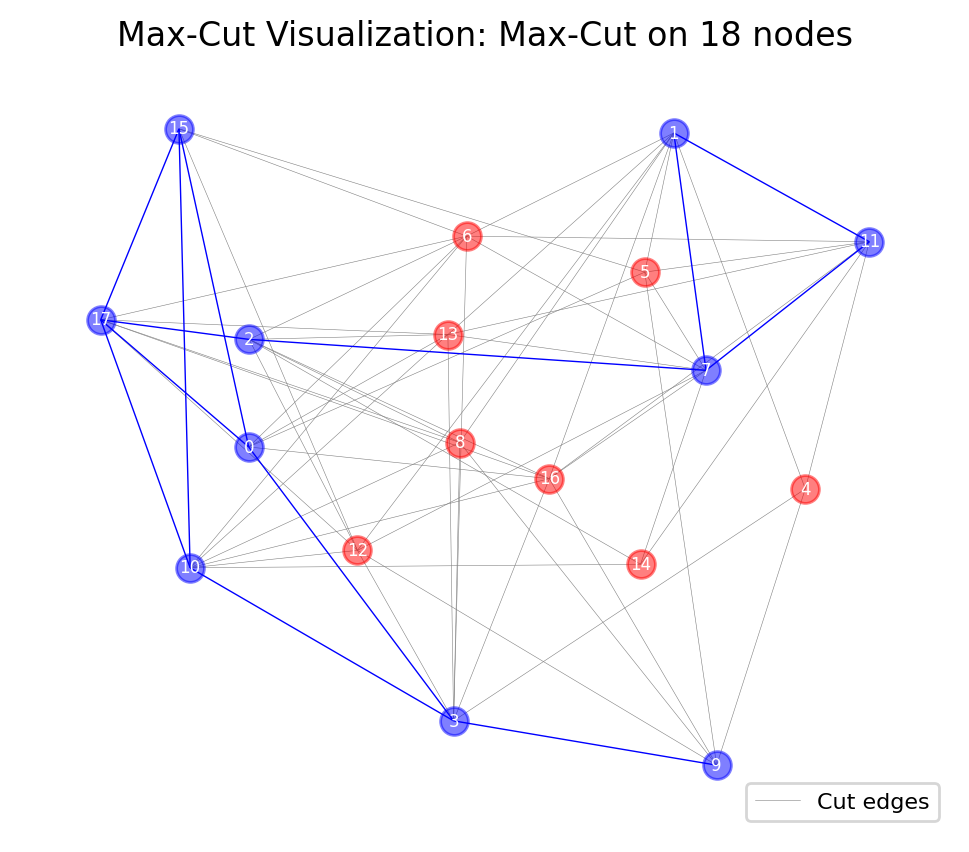

In [17]:
run_rbnbr(
    problem,
    X_type='relaxation',
    strategy='r3',
    topk=3,
    optim_params=qaoa_breadcrumbs.optim_params,
    qrr_information=qrr_solution.qrr_information
)

In [18]:
problem.solution_summary()

,Solution Type,Cut Value
0,Exact,56.0
4,Eigen,55.0
7,RBnBR_r2_k=3_relaxation,55.0
8,RBnBR_r3_k=3_relaxation,54.0
2,Goemans-Williamson,52.0
3,QRR,51.0
5,RBnBR_r1_k=3_corr,51.0
6,RBnBR_r1_k=3_relaxation,47.0
1,QAOA,34.0


In [19]:
problem.solutions('RBnBR_r2_k=3_relaxation').get_history(['cost'])

,cost
0,55.0
1,55.0
